## Notes

Have a number of epochs (num-epochs) and at the start of each epoch you reset the training state

Each epoch has a number (epoch-size) of batches and at the end of each batch you update the weights

The batch is what you pass into sess.run

The batch is X, Y where X has dim [batch-size, num-steps, num-features] and Y has dim [batch-size, num-steps]

In [72]:
import new_rnn_functions
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import shutil
import os
from tensorflow.contrib import predictor


2019-01-31 20:46:17,049 matplotlib.backends DEBUG    backend module://ipykernel.pylab.backend_inline version unknown


In [73]:
parameters = {
    "num_steps": 80,
    "batch_size": 150,
    "state_size": 15,
    "learning_rate": 0.1,
    "num_epochs": 2,
    "num_features": 3,
    "epoch_size": 200,
    "num_layers": 1,
    "num_level_updates": 40,
}

In [74]:
train_df, test_df = new_rnn_functions.load_data()


2019-01-31 20:46:17,078 root         DEBUG    loading entire df for river dart from sql
2019-01-31 20:46:18,256 root         DEBUG    Fill in missing timestamps by reindexing
2019-01-31 20:46:18,506 root         DEBUG    Convert cumulative rain to actual rain
2019-01-31 20:46:18,678 root         INFO     latest rain update at: 2018-08-19 21:00:00
2019-01-31 20:46:18,680 root         DEBUG    Concat rain and forecast to create model_rain
2019-01-31 20:46:18,693 root         DEBUG    interpolate model_rain


In [75]:
new_rnn_functions = reload(new_rnn_functions)


## Train model

EPOCH 0
('Average loss at step', 50, 'for last 50 steps:', 0.0909726433455944)
('Average loss at step', 100, 'for last 50 steps:', 0.04059880774468184)
('Average loss at step', 150, 'for last 50 steps:', 0.031131623592227698)
EPOCH 1
('Average loss at step', 50, 'for last 50 steps:', 0.018050351068377494)
('Average loss at step', 100, 'for last 50 steps:', 0.016588110364973544)
('Average loss at step', 150, 'for last 50 steps:', 0.014996327664703131)
INFO:tensorflow:Assets added to graph.


2019-01-31 20:47:07,393 tensorflow   INFO     Assets added to graph.


INFO:tensorflow:No assets to write.


2019-01-31 20:47:07,395 tensorflow   INFO     No assets to write.


INFO:tensorflow:SavedModel written to: /Users/jconn/isthedartrunning/analysis/models/test/saved_model.pb


2019-01-31 20:47:07,733 tensorflow   INFO     SavedModel written to: /Users/jconn/isthedartrunning/analysis/models/test/saved_model.pb


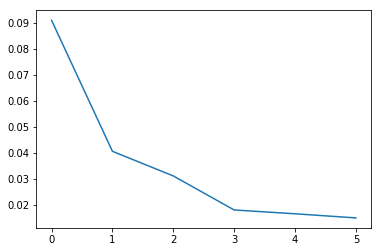

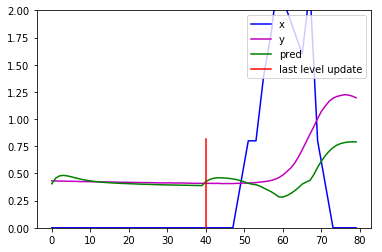

In [76]:
graph = new_rnn_functions.generate_graph(parameters)

training_losses, final_X, final_Y, final_pred = new_rnn_functions.run_training(train_df, parameters, graph, model_name="test")

plt.plot(training_losses)
plt.show()

# plot from the final predictions

new_rnn_functions.plot_sample(final_X, final_Y, final_pred, parameters=parameters, index=54)

In [77]:
def make_predictions(model_name, parameters, rain_threshold):
    cwd = os.getcwd()
    predict_fn = predictor.from_saved_model(os.path.join(cwd, "models", model_name))
    
    
    X_train, Y_train = new_rnn_functions.create_random_samples(train_df, parameters, rain_threshold=rain_threshold)
    
    train_pred = predict_fn({"x":X_train})["predictions"]
    train_bucket_pred = new_rnn_functions.bucket_predict({"x":X_train}, num_level_updates=parameters["num_level_updates"])
    
    train_errors = np.abs(np.array(Y_train) - np.array(train_pred))
    
    print "TRAIN DATA"
    print "\tMean absolute error:", train_errors.mean().round(4)
    print "\tRoot mean squared error:", round(math.sqrt((train_errors ** 2).mean()), 3)
    
    train_bucket_errors = np.abs(np.array(Y_train) - np.array(train_bucket_pred))
    print "\tMean absolute bucket_error:", train_bucket_errors.mean().round(4)
    print "\tRoot mean squared bucket_error:", round(math.sqrt((train_bucket_errors ** 2).mean()), 3)
    
    X_test, Y_test = new_rnn_functions.create_random_samples(test_df, parameters, rain_threshold=rain_threshold)
    
    test_pred = predict_fn({"x":X_test})["predictions"]
    test_bucket_pred = new_rnn_functions.bucket_predict({"x":X_test}, num_level_updates=parameters["num_level_updates"])

    print
    print "TEST DATA"
    test_errors = np.abs(np.array(Y_test) - np.array(test_pred))
    print "\tMean absolute error:", test_errors.mean().round(4)
    print "\tRoot mean squared error:", round(math.sqrt((test_errors ** 2).mean()), 3)
    
    test_bucket_errors = np.abs(np.array(Y_test) - np.array(test_bucket_pred))
    print "\tMean absolute bucket_error:", test_bucket_errors.mean().round(4)
    print "\tRoot mean squared bucket_error:", round(math.sqrt((test_bucket_errors ** 2).mean()), 3)

    return X_test, Y_test, test_pred, test_bucket_pred

X_test, Y_test, test_pred, test_bucket_pred = make_predictions(model_name = "test", parameters=parameters, rain_threshold=20)

INFO:tensorflow:Restoring parameters from /Users/jconn/isthedartrunning/analysis/models/test/variables/variables


2019-01-31 20:47:08,790 tensorflow   INFO     Restoring parameters from /Users/jconn/isthedartrunning/analysis/models/test/variables/variables


TRAIN DATA
	Mean absolute error: 0.0618
	Root mean squared error: 0.098
	Mean absolute bucket_error: 0.0794
	Root mean squared bucket_error: 0.248

TEST DATA
	Mean absolute error: 0.073
	Root mean squared error: 0.114
	Mean absolute bucket_error: 0.082
	Root mean squared bucket_error: 0.227


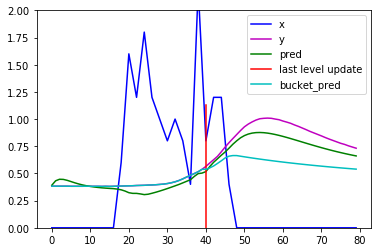

In [78]:
new_rnn_functions.plot_sample(X_test, Y_test, test_pred, parameters=parameters, bucket_pred=test_bucket_pred, index=1)